In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Set image dimensions and path
img_width, img_height = 128,128
train_data_dir = 'dataset'  # your main folder with mask/no_mask

# Preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

# Load images from folder
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 3274 images belonging to 2 classes.
Found 818 images belonging to 2 classes.


In [5]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
cnn_model = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25
)

# Save the model
model.save("face_mask_cnn_model.h5")

Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 388ms/step - accuracy: 0.7077 - loss: 0.5711 - val_accuracy: 0.9487 - val_loss: 0.1725
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - accuracy: 0.9058 - loss: 0.2458 - val_accuracy: 0.9499 - val_loss: 0.1367
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 48s 461ms/step - accuracy: 0.9018 - loss: 0.2332 - val_accuracy: 0.9597 - val_loss: 0.1301
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 47s 451ms/step - accuracy: 0.9168 - loss: 0.2176 - val_accuracy: 0.9548 - val_loss: 0.1478
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 49s 476ms/step - accuracy: 0.9350 - loss: 0.1751 - val_accuracy: 0.9413 - val_loss: 0.1908
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 452ms/step - accuracy: 0.9204 - loss: 0.1975 - val_accuracy: 0.9621 - val_loss: 0.1052
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - accuracy: 0.9373 - loss: 0.1546 - val_accuracy: 0.9621 - val_loss: 0.1149
Epoch 8/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.9444 - loss: 0

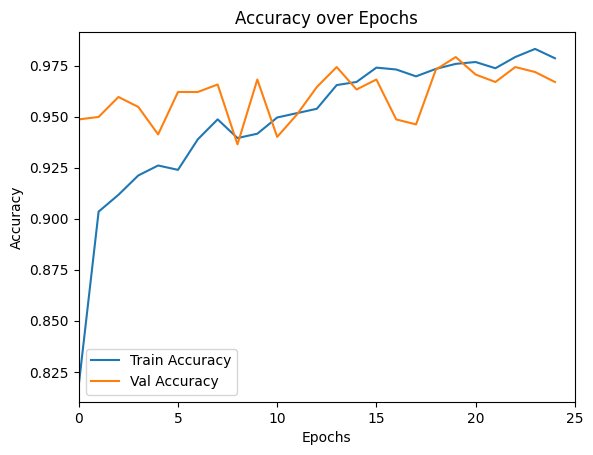

In [18]:
# Optional: Plot accuracy and loss
plt.plot(cnn_model.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_model.history['val_accuracy'], label='Val Accuracy')
plt.xlim(0,25)
plt.xlabel("Epochs")
plt.ylabel("Accuracy",size=10)
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [19]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your face mask detection model
model = load_model("face_mask_cnn_model.h5")

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        face_img = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_img, (128, 128))  # Resize to model input size
        face_array = np.expand_dims(face_resized, axis=0) / 255.0  # Normalize

        # Predict using the model
        prediction = model.predict(face_array)
        label = "Mask" if prediction[0][0] < 0.5 else "No Mask"

        # Display the results
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show the frame
    cv2.imshow("Face Mask Detection", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()


ModuleNotFoundError: No module named 'cv2'